# Annotate abundance changes with ClinVar labels

In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
dualipa_outputs = "../3_outputs"
metadata_outputs = "../../../1_allele_collection/3_outputs"
integrative_inputs = "../../../3_integrated_assay_results/1_inputs"

In [8]:
# process metadata
metadata = pl.DataFrame(pd.read_csv(f"{metadata_outputs}/varchamp_consolidated_alleles_clinvar_gnomad.tsv", sep="\t"))
mut_cols = ["mutation_id_rc4", "mutation_id_cegs2", "mutation_id_edgotyping3"]
id_vars = [col for col in metadata.columns if col not in mut_cols]
metadata = metadata.unpivot(index=id_vars, 
                            on=mut_cols,
                            variable_name="mutation_collection",
                            value_name="mut_id")

priority_col = ["orf_id", "mut_id", "symbol", "aa_change", "ensembl_gene_id", "clinvar_clnsig_clean", "gnomad_af", "StarStatus"]
metadata = metadata.select(priority_col).filter(~pl.col("mut_id").is_null()).with_columns(
    pl.col("mut_id").cast(pl.Int64).alias("mut_id"),
    pl.col("orf_id").cast(pl.Int64).alias("orf_id")
)

In [12]:
# merge scores with metadata
scores = pl.DataFrame(pd.read_csv(f"{dualipa_outputs}/DUALIPA_median_zscore.csv", sep=","))

scores = scores.with_columns(
    pl.col("orf_id").cast(pl.Int64).alias("orf_id"),
    pl.col("mut_id").cast(pl.Int64).alias("mut_id"),
)

scores = scores.join(metadata, on=["orf_id", "mut_id"], suffix='_meta')
scores = scores.filter(~pl.col("zscore_log2").is_null())

scores.write_csv(f"{dualipa_outputs}/annotated_perturbation_scores.csv")
scores.write_csv(f"{integrative_inputs}/abun_scores.csv")

scores = scores.filter(pl.col("clinvar_clnsig_clean") != "5_Others")

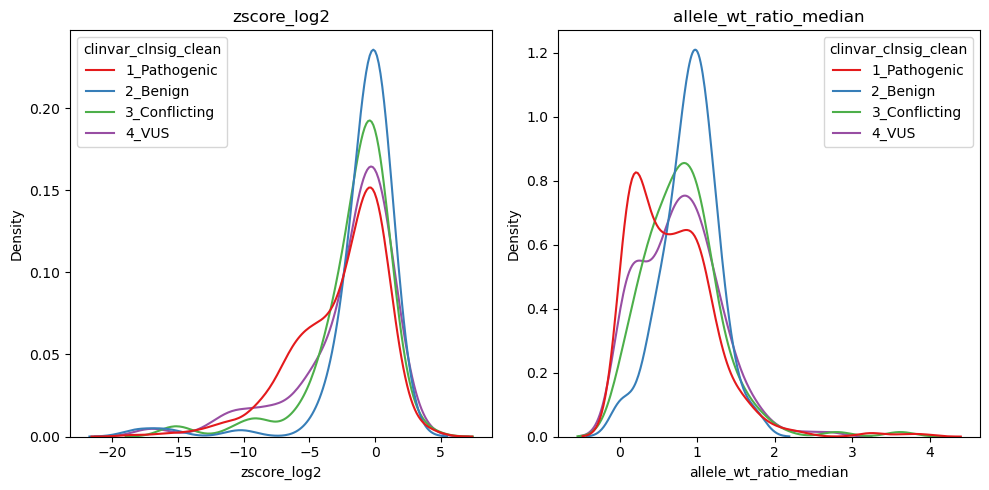

In [13]:
# Define variables to plot
variables = ["zscore_log2", "allele_wt_ratio_median"]
num_vars = len(variables)

# Create a FacetGrid for multiple subplots
fig, axes = plt.subplots(1, num_vars, figsize=(num_vars*5, 5))
hue_order = sorted(scores["clinvar_clnsig_clean"].drop_nulls().unique().to_list())
# Loop through variables and create subplots
for ax, var in zip(axes, variables):
    sns.kdeplot(
        data=scores,
        x=var,
        hue="clinvar_clnsig_clean",
        hue_order=hue_order,
        ax=ax,
        palette="Set1",
        common_norm=False
    )
    ax.set_title(var)
plt.tight_layout()
plt.show()

(863, 34)
(718, 34)


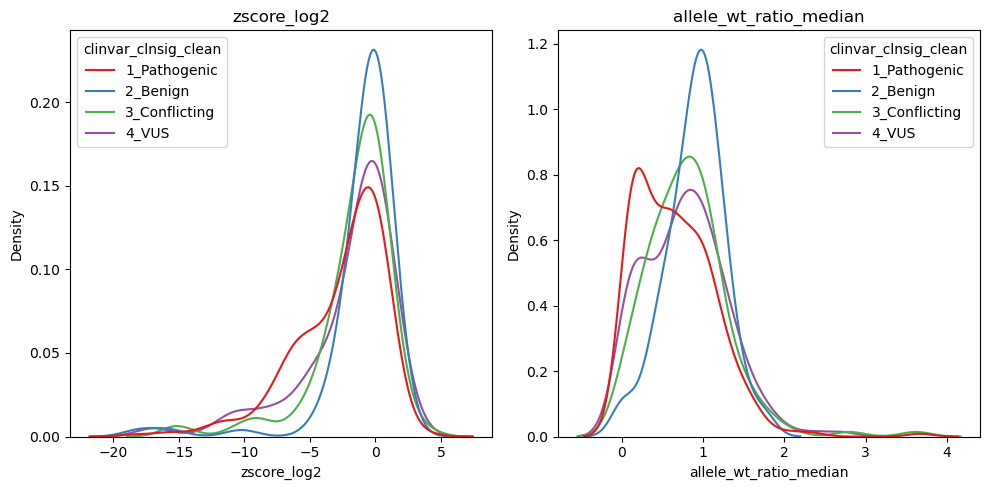

In [14]:
# Define variables to plot
variables = ["zscore_log2", "allele_wt_ratio_median"]
num_vars = len(variables)

print(scores.shape)
scores_filt = scores.filter(pl.col("StarStatus") >= 1)
print(scores_filt.shape)

# Create a FacetGrid for multiple subplots
fig, axes = plt.subplots(1, num_vars, figsize=(num_vars*5, 5))
hue_order = sorted(scores_filt["clinvar_clnsig_clean"].drop_nulls().unique().to_list())
# Loop through variables and create subplots
for ax, var in zip(axes, variables):
    sns.kdeplot(
        data=scores_filt,
        x=var,
        hue="clinvar_clnsig_clean",
        hue_order=hue_order,
        ax=ax,
        palette="Set1",
        common_norm=False
    )
    ax.set_title(var)
plt.tight_layout()
plt.show()

(83, 34)
(439, 34)
(188, 34)
(153, 34)


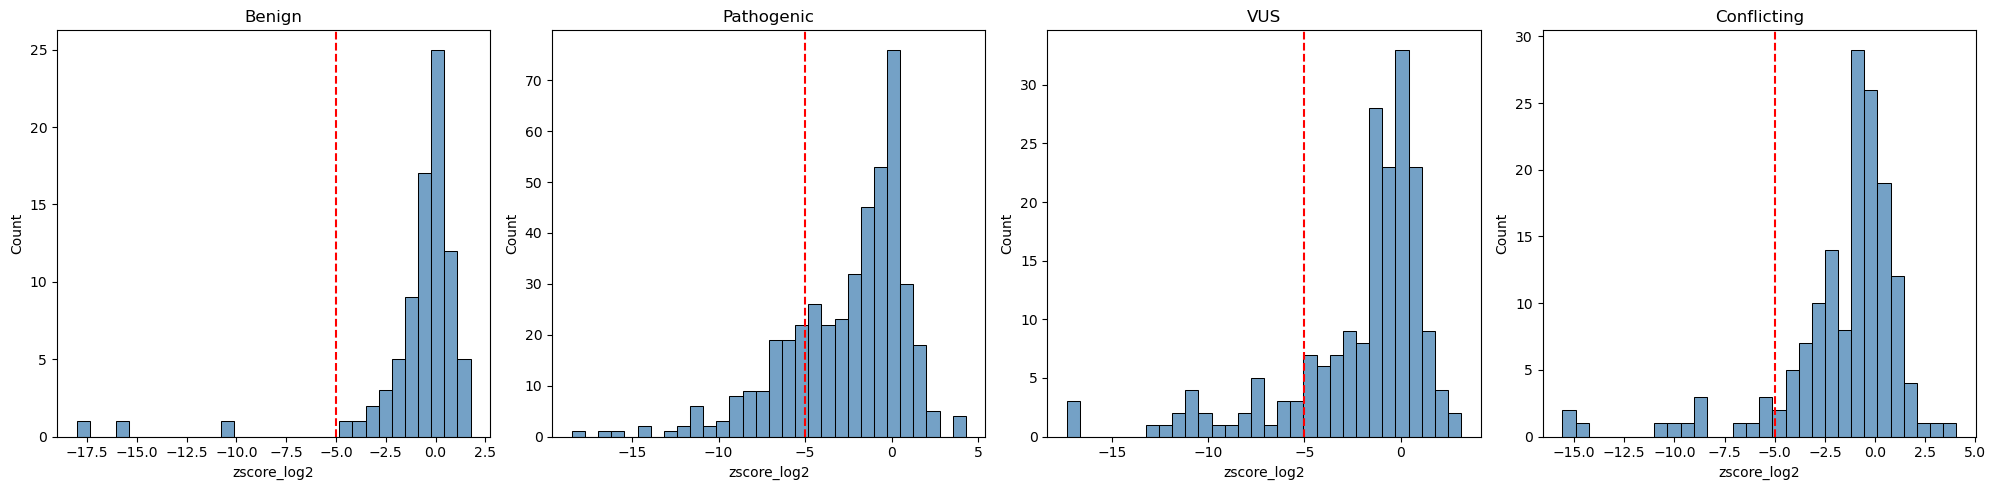

With this threshold, we classify 30 VUS and 14 conflicting alleles as pathogenic.
This threshold classifies 0.03614457831325301% of benign variants as pathogenic


In [15]:
plot_var = "zscore_log2"
thresh = -5

benign_scores = scores.filter(pl.col("clinvar_clnsig_clean") == "2_Benign")
print(benign_scores.shape)

path_scores = scores.filter(pl.col("clinvar_clnsig_clean") == "1_Pathogenic")
print(path_scores.shape)

vus_scores = scores.filter(pl.col("clinvar_clnsig_clean") == "4_VUS")
print(vus_scores.shape)

conf_scores = scores.filter(pl.col("clinvar_clnsig_clean") == "3_Conflicting")
print(conf_scores.shape)

# Setup subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
plot_data = [
    ("Benign", benign_scores, axs[0]),
    ("Pathogenic", path_scores, axs[1]),
    ("VUS", vus_scores, axs[2]),
    ("Conflicting", conf_scores, axs[3]),
]

# Plot each group
for title, data, ax in plot_data:
    sns.histplot(data=data, x=plot_var, bins=30, color="steelblue", kde=False, ax=ax)
    ax.axvline(thresh, color="red", linestyle="--", linewidth=1.5)
    ax.set_title(title)
    ax.set_xlabel(plot_var)
    ax.set_ylabel("Count")
    ax.grid(False)

plt.tight_layout()
plt.show()

benign_misclass = benign_scores.filter(pl.col(plot_var) < thresh).shape[0]
benign_total = benign_scores.shape[0]
print(f"With this threshold, we classify {vus_scores.filter(pl.col(plot_var) < thresh).shape[0]} VUS and {conf_scores.filter(pl.col(plot_var) < thresh).shape[0]} conflicting alleles as pathogenic.")
print(f"This threshold classifies {benign_misclass/benign_total}% of benign variants as pathogenic")

# This is ~13.4% of VUS/conflicting

In [16]:
path_scores.filter(pl.col(plot_var) < -5).shape[0] / path_scores.shape[0]

0.22779043280182232

In [17]:
# What percent of VUS/Conflicting are re-classified as pathogenic?
44 / (188+153)

0.12903225806451613